### Init

In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rich
from rich import pretty, print

plt.style.use("dark_background")
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 50
pd.options.display.max_rows = 50
pretty.install()

### Process Raw

In [73]:
df_train = pd.read_parquet("data/train_data.parquet")
df_train

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,reactivity_0004,reactivity_0005,reactivity_0006,reactivity_0007,reactivity_0008,reactivity_0009,reactivity_0010,reactivity_0011,reactivity_0012,reactivity_0013,reactivity_0014,reactivity_0015,reactivity_0016,reactivity_0017,reactivity_0018,...,reactivity_error_0182,reactivity_error_0183,reactivity_error_0184,reactivity_error_0185,reactivity_error_0186,reactivity_error_0187,reactivity_error_0188,reactivity_error_0189,reactivity_error_0190,reactivity_error_0191,reactivity_error_0192,reactivity_error_0193,reactivity_error_0194,reactivity_error_0195,reactivity_error_0196,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643675,7951fb2f47f1,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,DMS_MaP,SL5_M2seq_DMS,37530,7.248,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643676,e0dc5823e5e1,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,DMS_MaP,SL5_M2seq_DMS,337248,17.902,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643677,0d6036529b42,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,DMS_MaP,SL5_M2seq_DMS,44053,6.700,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643678,46d1f07d723b,GGGAACGACUCGAGUAGAGUCGAAAAGGAGCGUCGUGUCUCUUGUA...,DMS_MaP,SL5_M2seq_DMS,108600,11.716,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# Consolidate reactivity and reactivity_error columns into single column arrays
tmp = df_train.filter(like="reactivity_error_")
reactivity_error = pd.Series(list(tmp.values))
df_train = df_train.drop(columns=tmp.columns)
tmp = df_train.filter(like="reactivity_")
reactivity = pd.Series(list(tmp.values))
df_train = df_train.drop(columns=tmp.columns)
df_train["error"] = reactivity_error
df_train["react"] = reactivity

In [75]:
# Rename values and reorder columns for indexing
df_train["dataset_name"] = df_train["dataset_name"].apply(lambda x: x[:16] + x[20:] if x.endswith("EternaPlayers") else x[:-4])
df_train["experiment_type"] = df_train["experiment_type"].apply(lambda x: x[:3])
df_train = df_train[["sequence_id", "sequence", "dataset_name", "experiment_type", "reads", "signal_to_noise", "SN_filter", "react", "error"]]
df_train = df_train.rename(columns={"sequence_id": "seq_id", "sequence": "seq", "dataset_name": "dataset", "signal_to_noise": "SN"})

In [76]:
# Index and unstack to consolidate DMS and 2A3 rows
df_train = df_train.set_index(["seq_id", "seq", "dataset", "experiment_type"])
df_train = df_train.unstack()
# display(df_train.head(5))
# print(df_train.columns.values) # (reads, 2A3), (reads, DMS)
df_train.columns = ['_'.join(c) for c in df_train.columns.values]
df_train = df_train.reset_index()

In [77]:
df_train.head(1)

,seq_id,seq,dataset,reads_2A3,reads_DMS,SN_2A3,SN_DMS,SN_filter_2A3,SN_filter_DMS,react_2A3,react_DMS,error_2A3,error_DMS
0,00005a0b365f,GGGAACGACUCGAGUAGAGUCGAAAAGUGGGGUUUUCUAACACUAA...,DasLabBigLib_OneMil_RFAM_REP,3,2,0.014,0.007,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [78]:
# Remove trash sequences
df_train = df_train[(df_train.SN_2A3 > 0) | (df_train.SN_DMS > 0)]
df_train = df_train[(df_train.reads_2A3 > 0) | (df_train.reads_DMS > 0)]
nan_check = lambda x: np.isnan(x).all() == False
print(df_train.shape)
df_train = df_train[(df_train.react_2A3.apply(nan_check)) | (df_train.react_DMS.apply(nan_check))]
print(df_train.shape)
# Save
df_train.to_parquet("data/train_data_processed.parquet")

(791647, 13)

(791647, 13)

### Load

In [80]:
df_train = pd.read_parquet("data/train_data_processed.parquet")
df_train

,seq_id,seq,dataset,reads_2A3,reads_DMS,SN_2A3,SN_DMS,SN_filter_2A3,SN_filter_DMS,react_2A3,react_DMS,error_2A3,error_DMS
0,00005a0b365f,GGGAACGACUCGAGUAGAGUCGAAAAGUGGGGUUUUCUAACACUAA...,DasLabBigLib_OneMil_RFAM_REP,3,2,0.014,0.007,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,00006c296445,GGGAACGACUCGAGUAGAGUCGAAAAAGUGGCGGGCGCCUGUAGUC...,DasLabBigLib_OneMil_OpenKnot_Round_2_train,35,142,0.083,0.287,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,0000c9fe9c6f,GGGAACGACUCGAGUAGAGUCGAAAAGUAGAAUUGUUGAGCGUAAU...,DasLabBigLib_OneMil_Coronavirus_genomes_SARS_r...,33,152,0.160,0.382,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,0000d87cab97,GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...,DasLabBigLib_OneMil_RFAM_windows_100mers,827,3234,1.142,3.720,1,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,0000dadc9e14,GGGAACGACUCGAGUAGAGUCGAAAAAGCCGUCAGGUGUUCCUCCC...,DasLabBigLib_OneMil_15K_REP,13,33,-0.004,0.066,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
821835,ffffde700333,GGGAACGACUCGAGUAGAGUCGAAAAUCGGACGAAUUGAUGCACAC...,OpenKnot1_Twist_EternaPlayers,595,413,1.914,0.914,1,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
821836,ffffe6075b10,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGAAAGGCUGGAGCU...,DasLabBigLib_OneMil_RNAmake_designs_insert_bps...,7,66,0.034,0.071,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
821837,ffffea5adcdc,GGGAACGACUCGAGUAGAGUCGAAAACAGGCACAGUUCGCUGUGCC...,DasLabBigLib_OneMil_Single_nt_mutants_OpenKnot...,369,108,0.572,0.411,0,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
821838,fffff1a0b9c7,GGGAACGACUCGAGUAGAGUCGAAAAGAUAUGGACAUGAAGAGACA...,DasLabBigLib_OneMil_RNAmake_designs,808,753,0.934,1.420,0,1,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### EDA

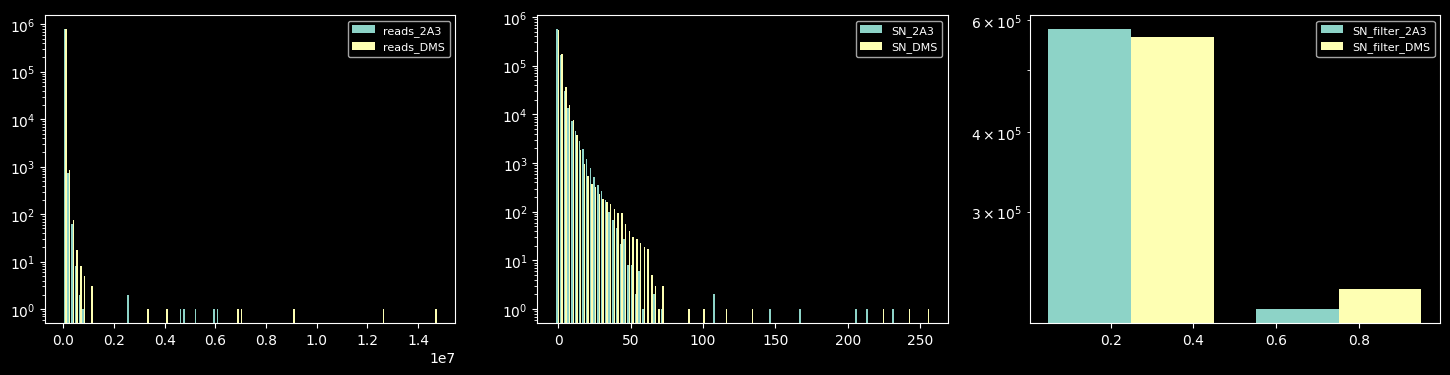

In [81]:
def tile_hist(df, labels, cols=4, sfigsize=(6, 4), log=True, bins=100):
    cols = len(labels) if len(labels) < cols else cols
    rows = math.ceil(len(labels) / cols)
    f, axs = plt.subplots(rows, cols, figsize=(sfigsize[0] * cols, sfigsize[1] * rows))
    axs = axs.flatten()
    for i in range(len(labels)):
        x = labels[i]
        b = len(np.unique(df[x].values.flatten()))
        axs[i].hist(df[x], label=x, log=log, bins=b if b < bins else bins)
        axs[i].legend(prop={"size": 8})
    plt.show()


hist_targets = [
    ["reads_2A3", "reads_DMS"],
    ["SN_2A3", "SN_DMS"],
    ["SN_filter_2A3", "SN_filter_DMS"],
]

tile_hist(df_train, hist_targets)